In [2]:
import tensorflow as tf


2022-05-02 19:55:10.721144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 19:55:10.721269: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from IPython.display import display, Image
import pandas as pd
import cv2
import numpy as np
import os

In [4]:
tf.config.list_physical_devices(
    device_type='GPU'
)

2022-05-02 19:55:16.837559: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[]

2022-05-02 19:55:16.837588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (karun-AORUS-15P-YD): /proc/driver/nvidia/version does not exist


### CHANGES THESE PATHS

In [5]:
train_path="/home/karun/Documents/Code/PlantCLEF2022/train/images"
test_path="/home/karun/Documents/Code/PlantCLEF2022/val/images"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [6]:
# print(class_names)
# print(class_names_test)
n=len(class_names)
input_shape=(224,224,3)
IMG_HEIGHT = 224
IMG_WIDTH = 224

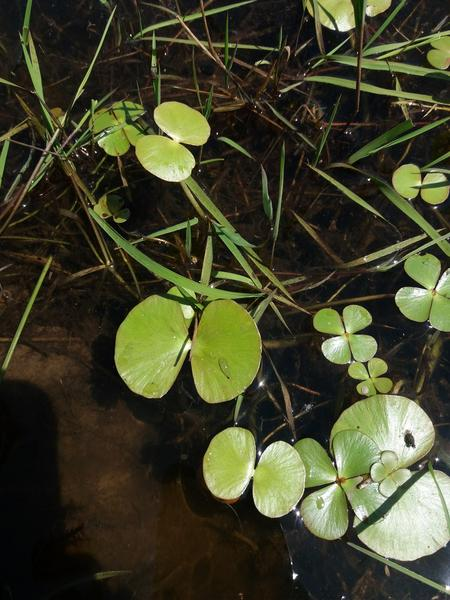

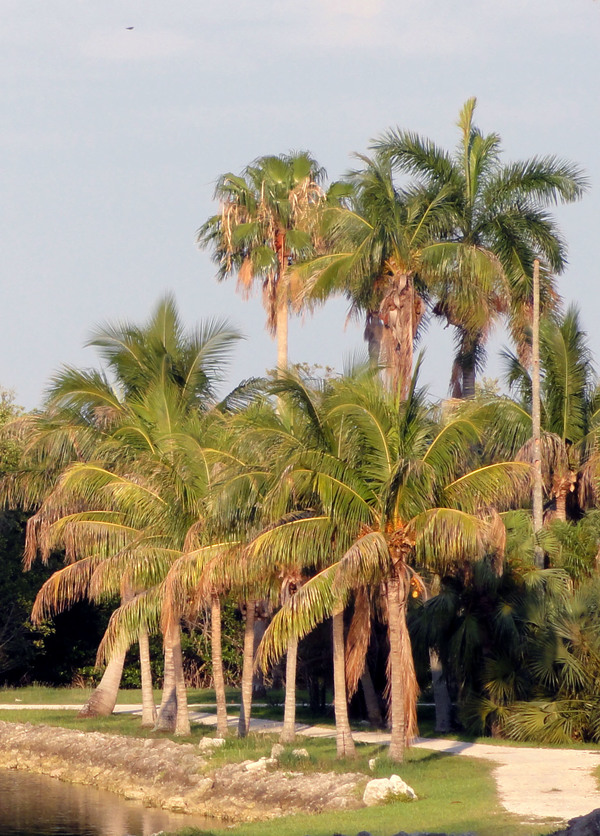

In [7]:
sample_image_1=Image('/home/karun/Documents/Code/PlantCLEF2022/train/images/2650087/51fc21c9fb76fb93885af19ef3260583dc009b4c.jpg')
display(sample_image_1)
sample_image_2=Image('/home/karun/Documents/Code/PlantCLEF2022/val/images/1204404/041ba2f5691c806a4e69625d71afeebca2d23aac.jpg')
display(sample_image_2)

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [9]:
train_generator = train_datagen.flow_from_directory(train_path,target_size=(224, 224),batch_size=450,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=450,shuffle=False,class_mode='categorical')

Found 2885052 images belonging to 80000 classes.
Found 1071627 images belonging to 80000 classes.


In [10]:
restnet = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
restnet = tf.keras.Model(restnet.input, outputs=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

2022-05-02 19:57:19.024059: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
model = tf.keras.Sequential()
model.add(restnet)
model.add(tf.keras.layers.Dense(512, activation='relu', input_dim=input_shape))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(n, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 51200)             21802784  
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 80000)             41040000  
                                                                 
Total params: 89,320,352
Trainable params: 67,517,568
No

/home/karun/.local/lib/python3.10/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
history = model.fit(train_generator, 
                    steps_per_epoch = 1000,
                    epochs=30,
                    validation_steps=50, 
                    verbose=1)

2022-05-02 19:57:33.294756: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 270950400 exceeds 10% of free system memory.


Epoch 1/30


2022-05-02 19:57:45.814753: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 270950400 exceeds 10% of free system memory.
2022-05-02 19:57:46.042791: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 709689600 exceeds 10% of free system memory.
2022-05-02 19:57:46.233554: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 684345600 exceeds 10% of free system memory.
2022-05-02 19:57:46.477093: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1368691200 exceeds 10% of free system memory.


 272/1000 [=======>......................] - ETA: 2:34:53 - loss: 11.2483 - accuracy: 4.9020e-05

In [ ]:
model.save('restnet.h5')

In [ ]:
image_path=os.path.join('/home/karun/Documents/Code/PlantCLEF2022/val/images/1204404/041ba2f5691c806a4e69625d71afeebca2d23aac.jpg')

In [ ]:
image = cv2.imread(image_path)
image = cv2.resize(image, (224,224))
# display(image)
preds = model.predict(np.expand_dims(image, axis=0))

In [ ]:
# print(preds)
#CHANGE TO SOFTMAX FOR PROBABILITIES
print(class_names[preds.argmax(axis=-1)[0]])

2847416
